## ADA Project Milestone 3: Final Project and Data Story

Complemented Notebook for Milestone 3.

General outline: 
- Data loading and cleaning of the datasets
- Data visualisation
- Examples of methods helping to create maps
- Speaker analysis
    - Topic detection in quotes
    - Regression to predict occupations of speakers
    - Sentiment analysis

In [120]:
# Main Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import time
from datetime import datetime

## Load datasets into pandas Dataframe
- _emdat_public_... is an additional dataset containing the main natural disasters that occured in the world
- _us_disaster_declarations_ is the additional dataset containing all natural disasters in the US from 1953 to 2021. <br>
- _natural_disaster_quotes_ dataset corresponds to the part of the Quotebank dataset that is useful for our project, i.e. it contains quotations citing the incident types. The type of incidents come from the incident_type column in the previous dataset. <br>
Note: We used the provided Google Colab notebook to generate the wanted compressed dataset.

In [121]:
# Load additional datasets

# World dataset : download at https://www.emdat.be/, select 'Natural'
# and the years from 1960 to 2020 and for all the continents (nd = natural disaters)
nd_world = pd.read_excel('data\emdat_public_2021_12_11_query_uid-ucCmQ2.xlsx', header=6)
nd_world.head(3)

C:\Users\rapha\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Dis No,Year,Seq,Glide,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Disaster Subsubtype,Event Name,...,"Reconstruction Costs, Adjusted ('000 US$)",Insured Damages ('000 US$),"Insured Damages, Adjusted ('000 US$)",Total Damages ('000 US$),"Total Damages, Adjusted ('000 US$)",CPI,Adm Level,Admin1 Code,Admin2 Code,Geo Locations
0,1960-0013-CHL,1960,13,NaN,Natural,Geophysical,Earthquake,Tsunami,NaN,NaN,...,NaN,NaN,NaN,550000.0,4813056.0,11.427251,NaN,NaN,NaN,NaN
1,1960-0026-AIA,1960,26,NaN,Natural,Meteorological,Storm,Tropical cyclone,NaN,Donna,...,NaN,NaN,NaN,35000.0,306285.0,11.427251,NaN,NaN,NaN,NaN
2,1960-0025-ANT,1960,25,NaN,Natural,Meteorological,Storm,Tropical cyclone,NaN,Donna,...,NaN,NaN,NaN,NaN,NaN,11.427251,NaN,NaN,NaN,NaN


In [122]:
nd_world.columns

Index(['Dis No', 'Year', 'Seq', 'Glide', 'Disaster Group', 'Disaster Subgroup',
       'Disaster Type', 'Disaster Subtype', 'Disaster Subsubtype',
       'Event Name', 'Country', 'ISO', 'Region', 'Continent', 'Location',
       'Origin', 'Associated Dis', 'Associated Dis2', 'OFDA Response',
       'Appeal', 'Declaration', 'Aid Contribution', 'Dis Mag Value',
       'Dis Mag Scale', 'Latitude', 'Longitude', 'Local Time', 'River Basin',
       'Start Year', 'Start Month', 'Start Day', 'End Year', 'End Month',
       'End Day', 'Total Deaths', 'No Injured', 'No Affected', 'No Homeless',
       'Total Affected', 'Reconstruction Costs ('000 US$)',
       'Reconstruction Costs, Adjusted ('000 US$)',
       'Insured Damages ('000 US$)', 'Insured Damages, Adjusted ('000 US$)',
       'Total Damages ('000 US$)', 'Total Damages, Adjusted ('000 US$)', 'CPI',
       'Adm Level', 'Admin1 Code', 'Admin2 Code', 'Geo Locations'],
      dtype='object')

In [123]:
# US dataset : download at https://www.kaggle.com/headsortails/us-natural-disaster-declarations
nd_frame = pd.read_csv('data/us_disaster_declarations.csv')
print("Column names and their data types (more info here: \
https://www.kaggle.com/headsortails/us-natural-disaster-declarations )\n")
print(nd_frame.dtypes)

Column names and their data types (more info here: https://www.kaggle.com/headsortails/us-natural-disaster-declarations )

fema_declaration_string       object
disaster_number                int64
state                         object
declaration_type              object
declaration_date              object
fy_declared                    int64
incident_type                 object
declaration_title             object
ih_program_declared            int64
ia_program_declared            int64
pa_program_declared            int64
hm_program_declared            int64
incident_begin_date           object
incident_end_date             object
disaster_closeout_date        object
fips                           int64
place_code                     int64
designated_area               object
declaration_request_number     int64
hash                          object
last_refresh                  object
id                            object
dtype: object


In [124]:
# Not all are "natural" disasters
nd_types = nd_frame.incident_type.unique()
print(nd_types)

['Tornado' 'Flood' 'Fire' 'Other' 'Earthquake' 'Hurricane' 'Volcano'
 'Severe Storm(s)' 'Toxic Substances' 'Typhoon' 'Drought'
 'Dam/Levee Break' 'Snow' 'Severe Ice Storm' 'Freezing' 'Coastal Storm'
 'Fishing Losses' 'Mud/Landslide' 'Human Cause' 'Terrorist' 'Tsunami'
 'Chemical' 'Biological']


This is the dictionary we use to extract relevant quotations from the Quotebank dataset. As we can see, some of them are similar (multiple kinds of storms), and others are not "natural" disasters (Human Cause, Terrorist, ...). Some modifications are done, for instance we must also add lowercase version of the terms, and we will also ignore some types of incidents in further analysis, e.g. Fire, Snow, ..., since they are hard to work with for what we want to accomplish. As we will see, some of these terms are used in other contexts that may be irrelevant. 

In [125]:
# Load quotation dataset

df_quotes = pd.read_json('data/natural_disaster_quotes.json.bz2', lines=True, compression='bz2')
print(f"Number of quotes: %d" % len(df_quotes.index))

Number of quotes: 1480711


We extracted another subset of QuoteBank with another dictionary for additional tests.

In [126]:
# Load 2nd quotation dataset with quotes containing climate/global warming related words 
# (['climate','warming','global','planet','carbon','environment','temperature'])
df_climate = pd.read_json('data/environment-quotes.json.bz2', lines=True, compression='bz2')
print(f"Number of quotes: %d" % len(df_climate.index))

Number of quotes: 1673053


In [127]:
print("Column names and their data types\n")
print(df_quotes.dtypes)

Column names and their data types

quoteID                   object
quotation                 object
speaker                   object
qids                      object
date              datetime64[ns]
numOccurrences             int64
probas                    object
urls                      object
phase                     object
dtype: object


In [128]:
df_quotes.head(3)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2020-01-13-009373,But he said `you're responsible. You make people think the wrong way about fires.,Tom Elliott,"[Q16196918, Q21461424, Q7815715, Q8952291]",2020-01-13 05:00:53,1,"[[Tom Elliott, 0.5795], [None, 0.4205]]",[https://www.3aw.com.au/tom-elliott-calls-for-an-end-to-finger-pointing-over-bushfire-crisis/],E
1,2020-03-11-014404,Everything that went wrong was always my fault. I remember one occasion where she missed a connection on a flight on or around Christmas Day in 2012. My aunt was visiting from Australia at that ti...,Kate James,[Q56379605],2020-03-11 13:04:58,2,"[[Kate James, 0.8144], [None, 0.1397], [Amber Heard, 0.0274], [Johnny Depp, 0.0185]]","[https://calgarysun.com/entertainment/celebrity/blind-rages-amber-heards-ex-assistant-accuses-her-of-physical-mental-abuse/wcm/20399017-6bf1-482b-bc0e-2b446cacac50, http://aceshowbiz.com/news/view...",E
2,2020-04-10-011917,"Great guy, messiest desk I ever saw, like a tornado hit a landfill but he knew where everything was! Funniest thing was the time the overnight cleaning crew left a full black garbage bag on his ch...",None,[],2020-04-10 04:00:00,3,"[[None, 0.7283], [Brad Harris, 0.2717]]","[http://newstimes.com/news/coronavirus/article/Popular-Ansonia-disc-jockey-dies-after-15193161.php?src=nthpcp, http://registercitizen.com/news/coronavirus/article/Popular-Ansonia-disc-jockey-dies-...",E


Some data preparations.

In [129]:
# Convert the datetime to a simpler format, only keep days (2020-04-26)
df_quotes['date'] = pd.to_datetime(df_quotes['date'].dt.strftime('%Y-%m-%d'))
df_climate['date'] = pd.to_datetime(df_climate['date'].dt.strftime('%Y-%m-%d'))

In [130]:
pd.options.display.max_colwidth = 200 # this is to see most of the text of the quotations
df_quotes.head().quotation
# Lots of irrelevant quotes! 

0                                                                                                                          But he said `you're responsible. You make people think the wrong way about fires.
1    Everything that went wrong was always my fault. I remember one occasion where she missed a connection on a flight on or around Christmas Day in 2012. My aunt was visiting from Australia at that ti...
2    Great guy, messiest desk I ever saw, like a tornado hit a landfill but he knew where everything was! Funniest thing was the time the overnight cleaning crew left a full black garbage bag on his ch...
3        How will they attend to the problems of the people without a full-fledged Ministry? You are not able to provide a Minister in charge of the districts. You are unable to take up flood relief work,
4                                                                                                                           I'm sure you hear it every day but you are smoking hot c

We can see that some terms of crisis can be used in other contexts. For instance, to exagerate a statement or there can be words (e.g. fire) that are used in a lot of fields.

## Data visualization and statistics

#### Data exploration of the Natural Disaster World dataset

In [131]:
L = list(nd_world.groupby('Disaster Type').groups.keys())
print(f"There are the following disaster categories in the dataset : {L}")
L_keep = ['Drought', 'Earthquake','Extreme temperature ', 'Flood', 'Storm', 'Wildfire']
nd_world = nd_world[nd_world['Disaster Type'].isin(L_keep)]
new_L = list(nd_world.groupby('Disaster Type').groups.keys())
print(f"We are only interested in the following : {new_L}")

There are the following disaster categories in the dataset : ['Animal accident', 'Drought', 'Earthquake', 'Epidemic', 'Extreme temperature ', 'Flood', 'Impact', 'Insect infestation', 'Landslide', 'Mass movement (dry)', 'Storm', 'Volcanic activity', 'Wildfire']
We are only interested in the following : ['Drought', 'Earthquake', 'Extreme temperature ', 'Flood', 'Storm', 'Wildfire']


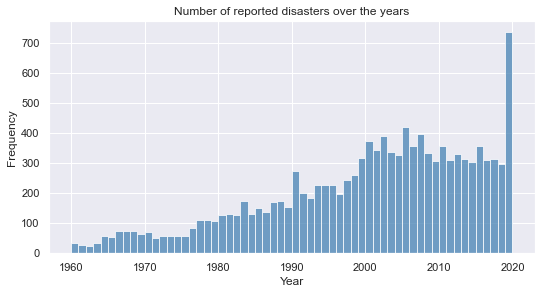

In [132]:
# Number of reported disasters per year
df_year = nd_world.groupby('Year').count()['Dis No']
sns.histplot(x=nd_world['Year'],bins=60,color='steelblue')
plt.ylabel('Frequency'); plt.xlabel('Year')
plt.title('Number of reported disasters over the years');

We see that the number of reported events in the dataset is roughly constant from 2000 on.

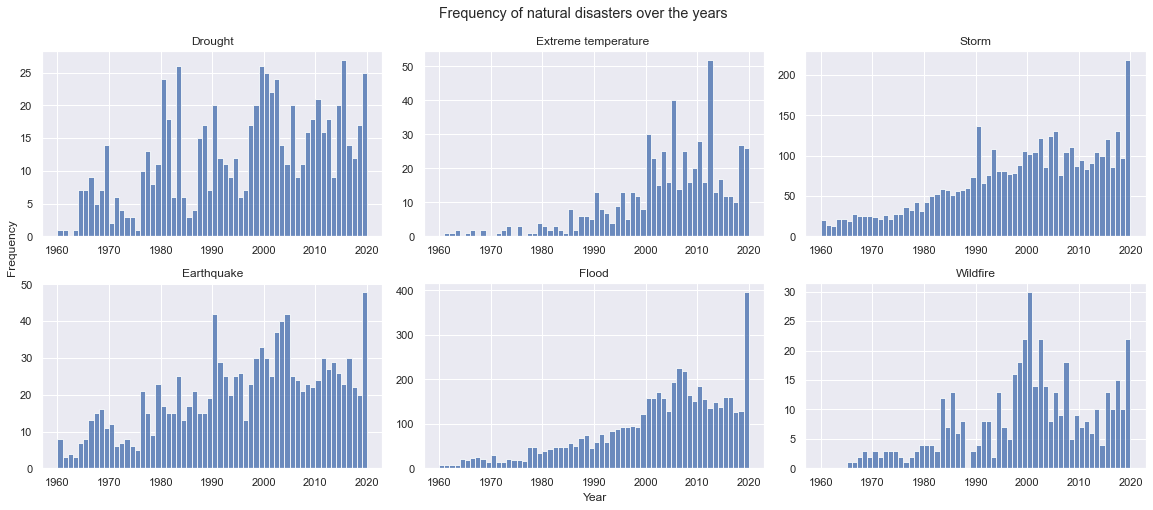

In [133]:
world_by_type = nd_world.copy().groupby('Disaster Type').apply(lambda x: pd.Series({
        'Year': x['Year'].values
    }))

fig, ax = plt.subplots(2, 3, figsize=(16,7), sharey=False, sharex=False)

for i in range(6):
    sbplt = ax[i%2, math.floor(i/2)]
    sbplt.hist(world_by_type.iloc[i].values, range=[1960,2020], bins = 60, alpha = 0.8)
    sbplt.set_title(world_by_type.index[i])

fig.text(0.5,0, "Year")
fig.text(0,0.45, "Frequency", rotation = 90)
fig.suptitle("Frequency of natural disasters over the years")
fig.tight_layout()

In [134]:
world_by_type = nd_world.copy()
# To divide the number of count by the number of quotes of the same year
world_by_type['count'] = world_by_type.apply(lambda x : 1/df_year[x['Year']], axis=1)
world_by_type = world_by_type[['Disaster Type','Year','count']]

world_by_type = world_by_type.groupby(['Disaster Type','Year']).sum()

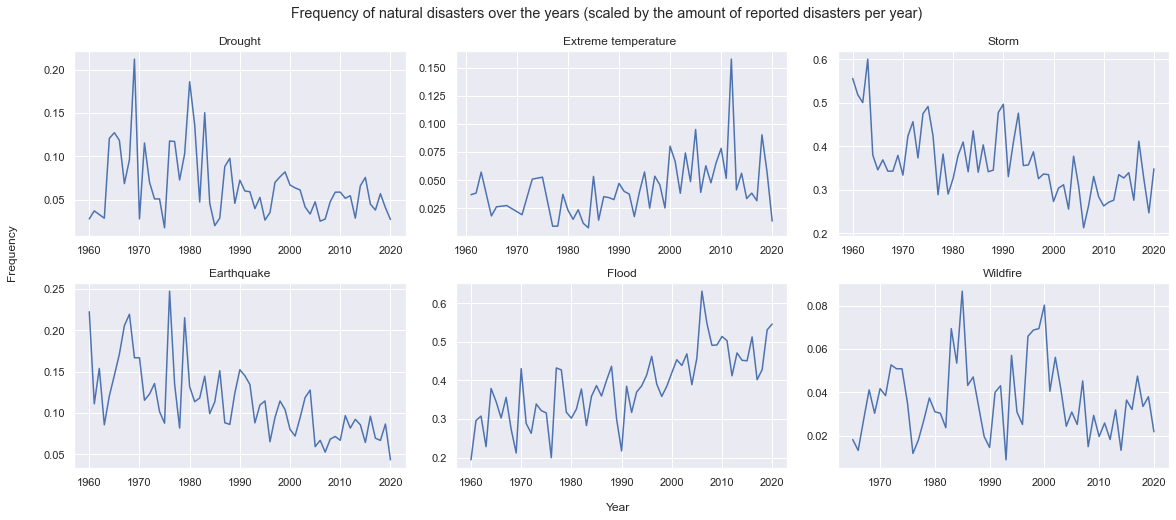

In [135]:
fig, ax = plt.subplots(2, 3, figsize=(16,7), sharey=False, sharex=False)

for i in range(6):
    sbplt = ax[i%2, math.floor(i/2)]
    df_tmp = world_by_type.loc[L_keep[i]]
    sbplt.plot(df_tmp)
    sbplt.set_title(L_keep[i])

fig.text(0.50,-0.02, "Year")
fig.text(-0.02,0.44, "Frequency", rotation = 90)
fig.suptitle("Frequency of natural disasters over the years (scaled by the amount of reported disasters per year)");
fig.tight_layout()

Analyse the frequency of floods over the years in Philippines, India, Bangladesh (n°1) or Indonesia

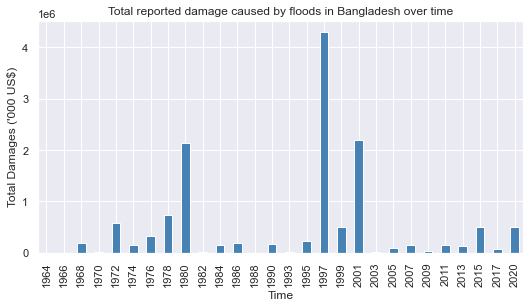

In [136]:
nd_bang = nd_world[nd_world['Country'] == 'Bangladesh'].copy()
nd_bang_flood = nd_bang[nd_bang['Disaster Type']=='Flood']
nd_bang_flood = nd_bang_flood.dropna(subset=["Total Damages ('000 US$)"])

fig, ax = plt.subplots(1,1)
nd_bang_flood["Total Damages ('000 US$)"].plot(kind='bar',color='steelblue')
plt.title('Total reported damage caused by floods in Bangladesh over time')
plt.xlabel('Time'); plt.ylabel("Total Damages ('000 US$)")
ax.set_xticklabels(np.linspace(start=1964,stop=2020,num=28).astype(int));


In [137]:
# Find country with the most floods => India, China, Indonesia
nd_flood = nd_world[nd_world['Disaster Type'] == 'Flood'].copy()
nd_flood = nd_flood.groupby('Country').count().reset_index()
nd_flood.sort_values('Year', ascending=False)[['Country','Seq']].head(4)

,Country,Seq
76,India,291
34,China,290
77,Indonesia,232
178,United States of America (the),180


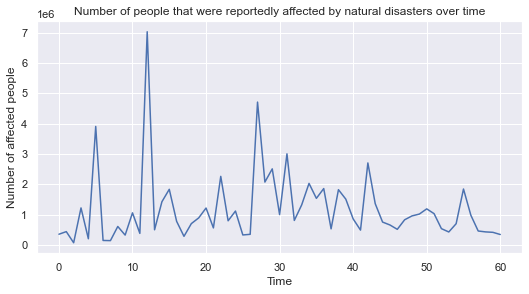

In [138]:
# How many people are affected by natural disasters over the years
nd_affected = nd_world.dropna(subset=['No Affected']).copy()
nd_affected['count'] = 1
nd_affected = nd_affected.groupby('Year').sum()[['count','No Affected']].reset_index().apply(lambda x : x['No Affected']/x['count'], axis=1)
sns.lineplot(data=nd_affected.values)
plt.title('Number of people that were reportedly affected by natural disasters over time')
plt.xlabel('Time'); plt.ylabel('Number of affected people');

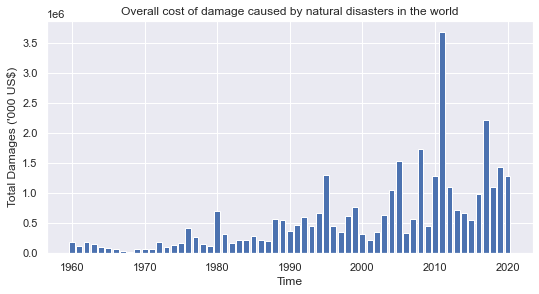

In [139]:
# How much damage caused by natural disasters over the years
class_ = "Total Damages ('000 US$)"
nd_damage = nd_world.dropna(subset=[class_]).copy()
nd_damage['count'] = 1
nd_damage = nd_damage.groupby('Year').sum()[['count',class_]].reset_index().apply(lambda x : x[class_]/x['count'], axis=1)
plt.bar(list(range(1960,2021)),nd_damage.values)
plt.title('Overall cost of damage caused by natural disasters in the world')
plt.xlabel('Time'); plt.ylabel("Total Damages ('000 US$)");

#### Data exploration of the US natural disaster dataset and of the quotes dataset

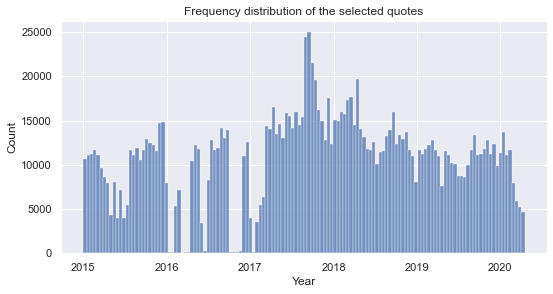

In [140]:
# Add a counter for later
df_quotes['count'] = 1
# Frequency histogram of the quotes w.r.t. dates
sns.set(rc={'figure.figsize':(8.7, 4.27)})
F = sns.histplot(df_quotes['date'])
F.set(title='Frequency distribution of the selected quotes',xlabel='Year');

In [141]:
# Extract main peaks of concern in the quotes dataset
df_tmp = df_quotes.copy()
# Count the amount of quotes per day
df_tmp['freq'] = df_tmp.groupby('date')['date'].transform(pd.Series.count)
# Sort them in descending order
df_tmp.sort_values('freq', inplace=True, ascending=False)
# To try to see what natural disaster caused the main peak in 2017-09 => Irma hurricane in first position
df_tmp.drop_duplicates(subset='freq')[['date','urls','freq']].head(4)

,date,urls,freq
963672,2017-09-12,[http://www.islander.org/2017/09/irma-arrives-anna-maria-island-spared-for-most-part/],2636
805802,2017-08-30,"[http://business-standard.com/article/news-ians/government-open-for-dialogue-with-all-in-kashmir-but-no-preconditions-home-secretary-ians-interview-117083001482_1.html, http://morungexpress.com/go...",2627
1035584,2017-09-07,[https://www.sungazette.com/news/top-news/2017/09/former-city-councilman-tries-another-run-at-seat/],2587
828388,2017-09-08,[https://www.cardschat.com/news/florida-poker-rooms-close-cancel-tourneys-hurricane-irma-approaches-51047],2563


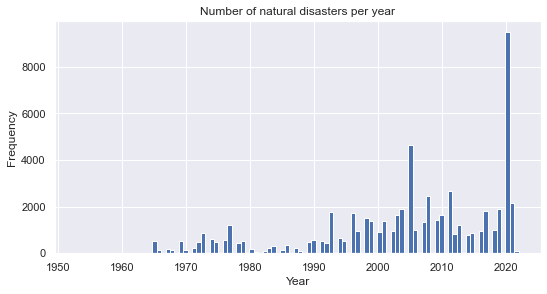

In [142]:
# Natural disasters per year
nd_frame['fy_declared'].hist(bins=100)
plt.title("Number of natural disasters per year")
plt.xlabel("Year")
plt.ylabel("Frequency");


In the graph above, we easily observe that a large number of crisis happened in 2020. With further investigation of the natural disaster dataset, we see that this mainly represents "Biological" disasters (see following plots), most notably Covid-19. We decided to ignore these types of incident going further, since it is a worldwide pandemic and does not have a fixed time period.

In [143]:
# get data rows from 2015 to 2020 and drop irrelevant rows
nd_frame.drop(nd_frame[nd_frame['fy_declared'] < 2015].index, inplace = True)
nd_frame.drop(nd_frame[nd_frame['fy_declared'] > 2020].index, inplace = True)

nd_frame.drop(nd_frame[nd_frame.incident_type == "Other"].index, inplace = True)
print(nd_frame.head().iloc[:, :7])

      fema_declaration_string  disaster_number state declaration_type  \
44317              DR-4197-NM             4197    NM               DR   
44318              DR-4197-NM             4197    NM               DR   
44319              DR-4197-NM             4197    NM               DR   
44320              DR-4197-NM             4197    NM               DR   
44321              DR-4197-NM             4197    NM               DR   

           declaration_date  fy_declared    incident_type  
44317  2014-10-06T19:20:00Z         2015  Severe Storm(s)  
44318  2014-10-06T19:20:00Z         2015  Severe Storm(s)  
44319  2014-10-06T19:20:00Z         2015  Severe Storm(s)  
44320  2014-10-06T19:20:00Z         2015  Severe Storm(s)  
44321  2014-10-06T19:20:00Z         2015  Severe Storm(s)  


In [144]:
print(f"Number of natural disasters from 2015 to 2020: %d" % len(nd_frame.index))

Number of natural disasters from 2015 to 2020: 16068


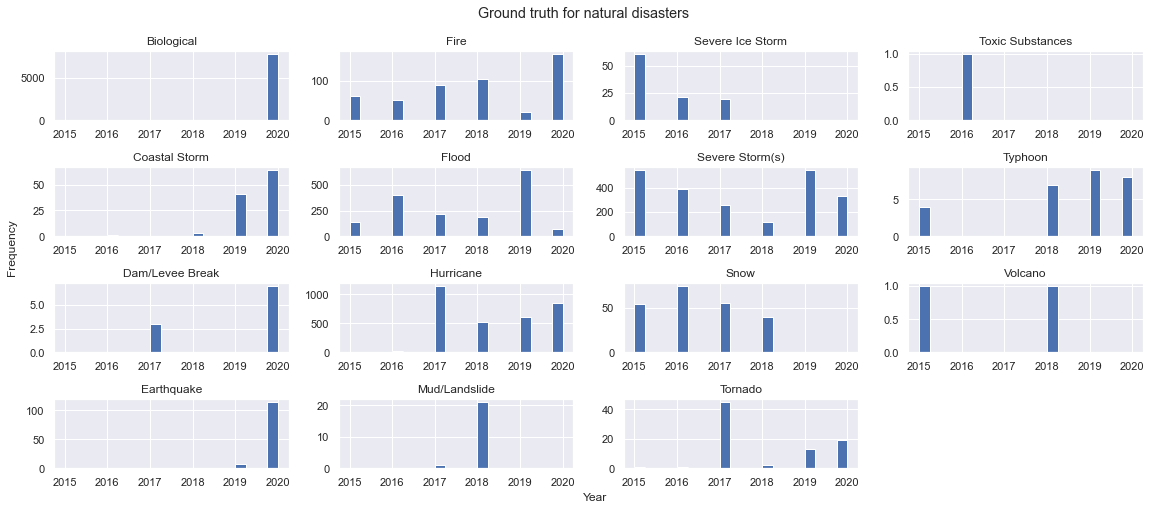

In [145]:
# "Ground truth" plots

stats_by_type = nd_frame.groupby('incident_type').apply(lambda x: pd.Series({
        'fy_declared': x['fy_declared'].values
    }))

fig, ax = plt.subplots(4, 4, figsize=(16,7), sharey=False, sharex=False)

for i in range(15):
    sbplt = ax[i%4, math.floor(i/4)]
    sbplt.hist(stats_by_type.iloc[i].values, range=[2015,2020], bins = 20)
    sbplt.set_title(stats_by_type.index[i])
    
fig.text(0.5,0, "Year")
fig.text(0,0.45, "Frequency", rotation = 90)
fig.delaxes(ax[3][3])
fig.suptitle("Ground truth for natural disasters")
fig.tight_layout()

These are the occurences of the disasters that really happend. As previously said, we see most notably that "Biological" incident happend almost only in 2020. We will now see if it is possible to observe the catastrophes only from the quotations.

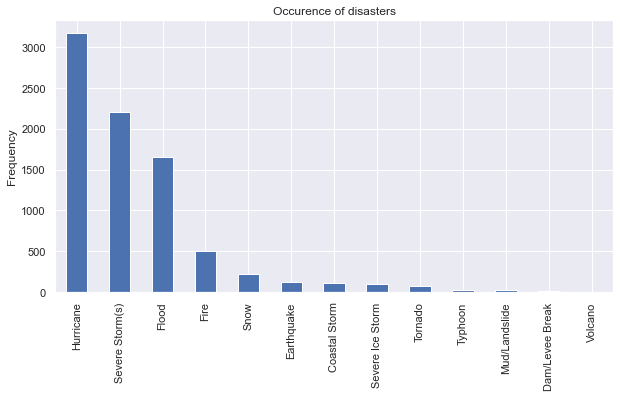

In [146]:
# Occurence of different disasters
# Remove Biological and Toxic Substances disasters
nd_frame.drop(nd_frame[nd_frame['incident_type'] == 'Biological'].index, inplace= True)
nd_frame.drop(nd_frame[nd_frame['incident_type'] == 'Toxic Substances'].index, inplace= True)
nd_frame['incident_type'].value_counts().plot(kind='bar', figsize=(10, 5), title="Occurence of disasters")
plt.ylabel("Frequency");

In [147]:
# Separate quotes in different dataframes with respect to the type of disaster
def get_occurrence(df, string):
    low_str = string.lower()
    return df[df['quotation'].apply(lambda s: s.lower()).str.contains(low_str)]

df_hurricane = get_occurrence(df_quotes, "hurricane")
df_typhoon = get_occurrence(df_quotes, "typhoon")
df_tornado = get_occurrence(df_quotes, "tornado")
df_flood = get_occurrence(df_quotes, "flood")
# can be more precise, need to explore further
df_storm = get_occurrence(df_quotes, "storm")
df_volcano = get_occurrence(df_quotes, "volcano")
# !!! Fire pretty general term -> discuss that there are a lot of irrelevant quotes
df_fire = get_occurrence(df_quotes, "fire")
df_landslide = get_occurrence(df_quotes, "landslide")
df_earthquake = get_occurrence(df_quotes, "earthquake")
df_dam = get_occurrence(df_quotes, "dam")

In [148]:
df_climate_tmp = df_climate[df_climate['date'] >= '2017']
df_climate_change = get_occurrence(df_climate_tmp, "climate change")
df_carbon = get_occurrence(df_climate_tmp, "carbon")

To have an idea of the trend, we can focus on the years 2017 to 2020. As we saw before with the distribution of the quotes over the years, it is quite inconsistent from 2015 to 2017 with notable gaps and variations in the amount of quotes published every year. It stays quite constant from 2017 on, and it seems like there is an increase in the use of these two words in the media over the years, which could suggest that there's growing concern over the climate change as these two queries are quite specific to the topic of the environment.

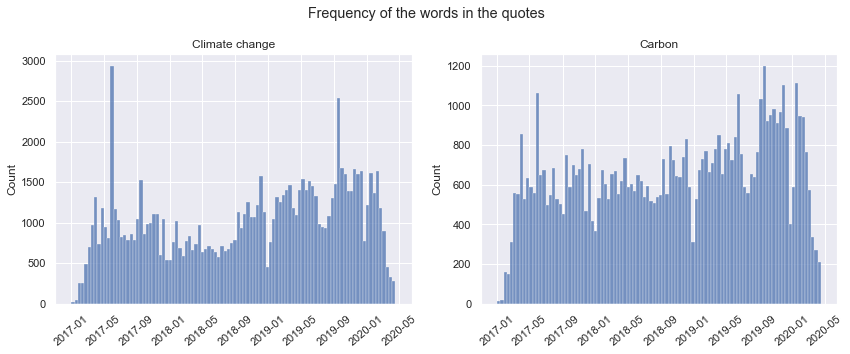

In [149]:
# Plot frequency of each combination of word over time
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Frequency of the words in the quotes')

nb_bins = 100

F1 = sns.histplot(df_climate_change["date"].values, ax=axes[0], bins=nb_bins)
F1.set(title='Climate change')
F2 = sns.histplot(df_carbon["date"].values, ax=axes[1], bins=nb_bins)
F2.set(title='Carbon')

axes[0].tick_params(axis='x', rotation=40)
axes[1].tick_params(axis='x', rotation=40)

fig.tight_layout()

In [150]:
# Basic statistics per incident type
print(f"Number of quotes for Hurricanes: %d" % len(df_hurricane.index))
print(f"Number of quotes for Typhoons: %d" % len(df_typhoon.index))
print(f"Number of quotes for Tornados: %d" % len(df_tornado.index))
print(f"Number of quotes for Floods: %d" % len(df_flood.index))
print(f"Number of quotes for Storms: %d" % len(df_storm.index))
print(f"Number of quotes for Volcanos: %d" % len(df_volcano.index))
print(f"Number of quotes for Fires: %d" % len(df_fire.index))
print(f"Number of quotes for Landslides: %d" % len(df_landslide.index))
print(f"Number of quotes for Earthquakes: %d" % len(df_earthquake.index))
print(f"Number of quotes for Dam breaks: %d" % len(df_dam.index))

Number of quotes for Hurricanes: 57043
Number of quotes for Typhoons: 3827
Number of quotes for Tornados: 12096
Number of quotes for Floods: 118441
Number of quotes for Storms: 153573
Number of quotes for Volcanos: 6277
Number of quotes for Fires: 692022
Number of quotes for Landslides: 7748
Number of quotes for Earthquakes: 24523
Number of quotes for Dam breaks: 34599


Plots of natural disasters with respect to their date.

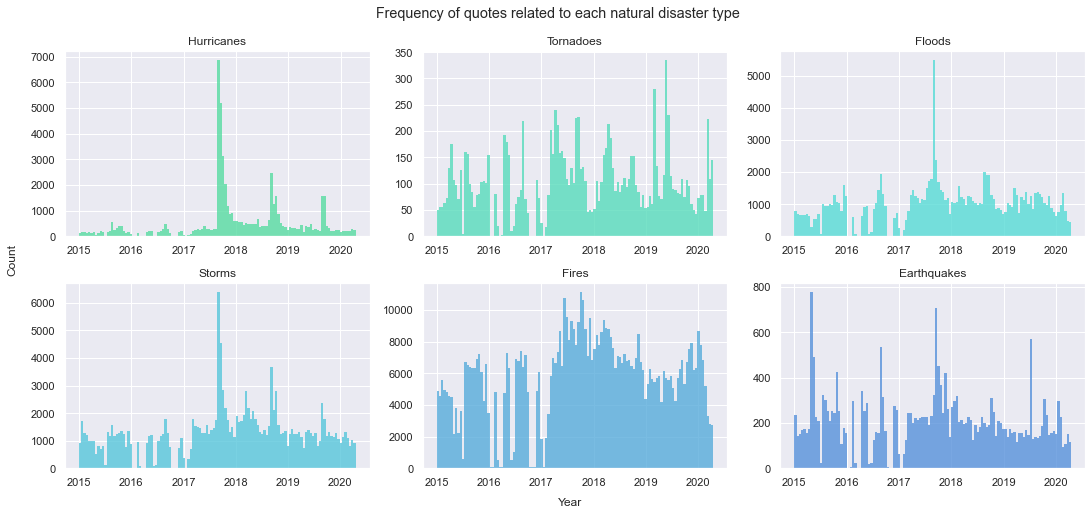

In [161]:
# hurr, tornado, flood, storm, fires, earthquakes

fig, axes = plt.subplots(2, 3, figsize=(15, 7), sharex=False, sharey=False)

i = 25

nb_bins = 120
col = sns.color_palette("hls", 60)
F0 = sns.histplot(x=df_hurricane['date'], bins=nb_bins, ax=axes[0,0], linewidth=0.01, alpha=0.8, color=col[i])
F0.set(xlabel=None, ylabel=None, title='Hurricanes')
F1 = sns.histplot(x=df_tornado['date'], bins=nb_bins, ax=axes[0,1], linewidth=0.01, alpha=0.8, color=col[i+2])
F1.set(xlabel=None, ylabel=None, title='Tornadoes')
F2 = sns.histplot(x=df_flood['date'], bins=nb_bins, ax=axes[0,2], linewidth=0.01, alpha=0.8, color=col[i+4])
F2.set(xlabel=None, ylabel=None, title='Floods')
F3 = sns.histplot(x=df_storm['date'], bins=nb_bins, ax=axes[1,0], linewidth=0.01, alpha=0.8, color=col[i+6])
F3.set(xlabel=None, ylabel=None, title='Storms')
F4 = sns.histplot(x=df_fire['date'], bins=nb_bins, ax=axes[1,1], linewidth=0.01, alpha=0.8, color=col[i+8])
F4.set(xlabel=None, ylabel=None, title='Fires')
F5 = sns.histplot(x=df_earthquake['date'], bins=nb_bins, ax=axes[1,2], linewidth=0.01, alpha=0.8, color=col[i+10])
F5.set(xlabel=None, ylabel=None, title='Earthquakes')


fig.text(0.5,-0.01, "Year")
fig.text(-0.01,0.45, "Count", rotation = 90)
fig.suptitle('Frequency of quotes related to each natural disaster type')
fig.tight_layout()

Closer look on the earthquake data

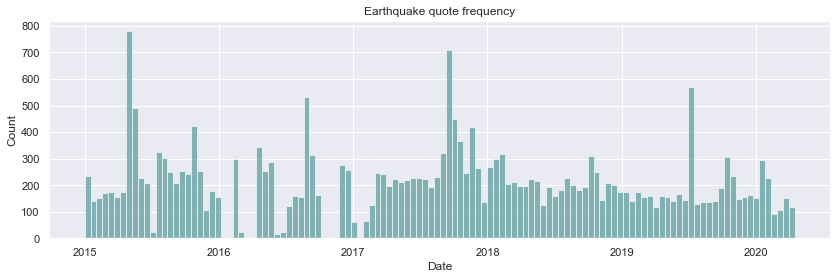

In [152]:
plt.figure(figsize=(14,4))
sns.histplot(x=df_earthquake['date'],bins=120,color='cadetblue')
plt.title("Earthquake quote frequency")
plt.xlabel("Date")
plt.ylabel("Count");

Analysis of the main peaks in quotations for the earthquakes to detect the ones that had the biggest impact in the quotes

In [154]:
# Earthquake as there are multiple peaks of similar amplitude
df_tmp = df_earthquake.copy()
# Count the amount of quotes per day
df_tmp['freq'] = df_tmp.groupby('date')['date'].transform(pd.Series.count)
# Sort them in descending order
df_tmp.sort_values('freq', inplace=True, ascending=False)

# Retrieve the dates at which the main peaks happen and make it a list to analyse it

# To try to see what natural disaster caused the main peak in 2017-09 => Irma hurricane in first position
earth_peak_dates = df_tmp.drop_duplicates(subset='freq')[['date','freq']].apply(lambda x : [str(x['date'])[:10],x['freq']], axis=1)
print(f"Dates with most occurences of earthquakes in the press [date, count] :\n{earth_peak_dates.head(15)}")

Dates with most occurences of earthquakes in the press [date, count] :
1322811    [2015-04-27, 187]
887548     [2017-09-20, 165]
278567     [2019-07-06, 135]
1329868    [2015-04-28, 134]
1063680    [2016-08-24, 131]
1334882    [2015-04-26, 101]
1264056    [2015-04-25, 100]
772980      [2017-09-19, 80]
726869      [2017-09-21, 78]
1440616     [2015-10-26, 77]
125077      [2019-10-17, 74]
188414      [2019-07-05, 73]
707882      [2017-09-08, 71]
1140965     [2016-08-25, 70]
1148927     [2016-04-19, 68]
dtype: object


From those and looking at the earthquake histogram in the previous section, we confirm that the earthquakes that triggered the biggest reactions in the media are eathquakes from :
- Nepal (April 2015)
- Mexico (September 2017)
- California (July 2019)
- Italy (August 2016)
- Pakistan/Afghanistan (October 2015)
- Philippines (October 2019)
- Mexico (September 2017), 1st of the two that occured in Mexico at that time (1st on the 7th, 2nd on the 19th)

In [156]:
# To extract all the quotes that contain one of the words in str_list
def get_quotes(df, str_list):
    return df[df['quotation'].apply(lambda s: any(word.lower() in s.lower() for word in str_list))]

df_iran = get_quotes(df_earthquake, ['iran','halabja','ezgeleh']) # Words to target the earthquake that occured in Iran
df_italy = get_quotes(df_earthquake, ['accumoli','italy','italia','perugia','aquila','appenines']) # Same with the one in Italy

Dates with most occurences of earthquakes in the press [date, count] :
872906     [2017-11-13, 11]
907172      [2017-11-14, 9]
924172      [2017-11-15, 7]
762947      [2017-11-16, 4]
1026696     [2017-10-09, 3]
349503      [2018-06-27, 2]
1352541     [2015-11-17, 1]
dtype: object


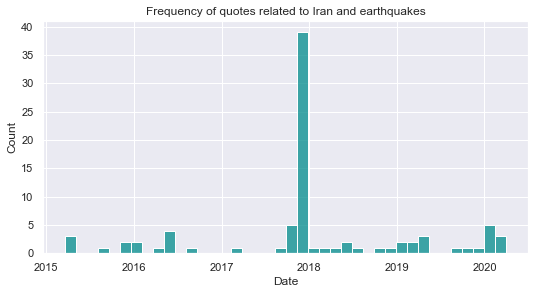

In [160]:
df_tmp = df_iran.copy()

sns.histplot(x=df_tmp['date'],bins=40,color='darkcyan')
plt.title('Frequency of quotes related to Iran and earthquakes')
plt.xlabel("Date")
plt.ylabel("Count")

df_tmp = df_iran.copy()
# Count the amount of quotes per day
df_tmp['freq'] = df_tmp.groupby('date')['date'].transform(pd.Series.count)
# Sort them in descending order
df_tmp.sort_values('freq', inplace=True, ascending=False)

# Retrieve the dates at which the main peaks happen and make it a list to analyse it

# To try to see what natural disaster caused the main peaks
peak_dates = df_tmp.drop_duplicates(subset='freq')[['date','freq']].apply(lambda x : [str(x['date'])[:10],x['freq']], axis=1)
print(f"Dates with most occurences of earthquakes in the press [date, count] :\n{peak_dates.head(20)}")

Dates with most occurences of earthquakes in the press [date, count] :
1150091    [2016-08-24, 50]
1141256    [2016-08-25, 22]
1114029    [2016-08-26, 12]
1163300     [2016-08-27, 4]
1068369     [2016-09-01, 3]
1161055     [2016-05-31, 2]
465516      [2018-03-05, 1]
dtype: object


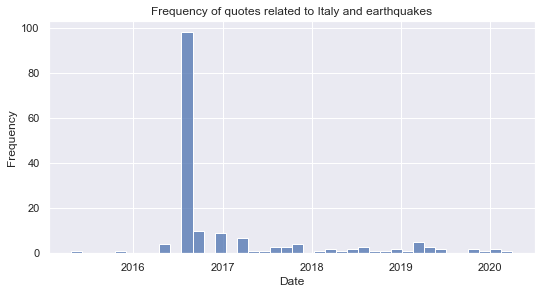

In [159]:
df_tmp = df_italy.copy()

sns.histplot(x=df_tmp['date'],bins=40)
plt.title('Frequency of quotes related to Italy and earthquakes')
plt.xlabel("Date")
plt.ylabel("Frequency")

df_tmp = df_italy.copy()
# Count the amount of quotes per day
df_tmp['freq'] = df_tmp.groupby('date')['date'].transform(pd.Series.count)
# Sort them in descending order
df_tmp.sort_values('freq', inplace=True, ascending=False)

# Retrieve the dates at which the main peaks happen and make it a list to analyse it

# To try to see what natural disaster caused the main peaks
peak_dates = df_tmp.drop_duplicates(subset='freq')[['date','freq']].apply(lambda x : [str(x['date'])[:10],x['freq']], axis=1)
print(f"Dates with most occurences of earthquakes in the press [date, count] :\n{peak_dates.head(20)}")

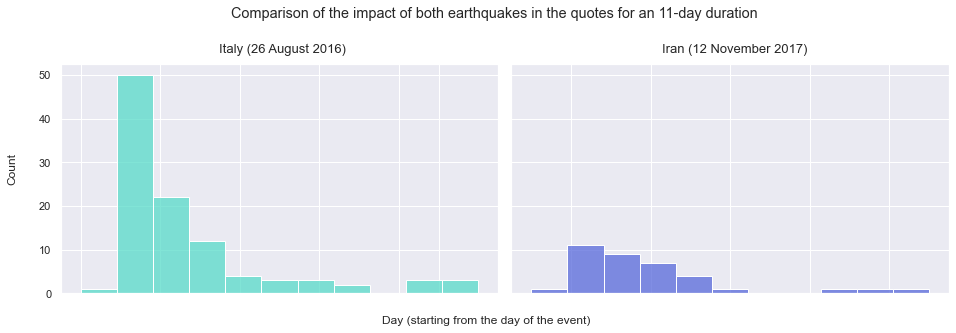

In [168]:
# Plot the 11-days window of time around the occurence of the earthquake of the two main earthquakes (Iran and Italy)

fig_e, ax_e = plt.subplots(1,2,figsize=(13,4),sharex=False,sharey=True)

df_it_tmp = df_italy.copy()[(df_italy['date'] > '2016-08') & (df_italy['date'] <= '2016-09-02')]
df_ir_tmp = df_iran.copy()[(df_iran['date'] > '2017-11') & (df_iran['date'] <= '2017-11-22')]
nb_bins = 11

col = sns.color_palette("hls", 60)

F0 = sns.histplot(x=df_it_tmp['date'], ax=ax_e[0], bins=nb_bins, color=col[28])
F0.set(xlabel=None, ylabel=None, xticklabels=[])
F1 = sns.histplot(x=df_ir_tmp['date'], ax=ax_e[1], bins=nb_bins, color=col[38])
F1.set(xlabel=None, ylabel=None, xticklabels=[])

fig_e.suptitle('Comparison of the impact of both earthquakes in the quotes for an 11-day duration',y=1.06)
fig_e.text(0.206, 0.9, 'Italy (26 August 2016)', fontsize=13)
fig_e.text(0.68, 0.9, 'Iran (12 November 2017)', fontsize=13)
fig_e.text(0.38, -0.04, "Day (starting from the day of the event)")
fig_e.text(-0.02, 0.45, "Count", rotation = 90)
fig_e.tight_layout()

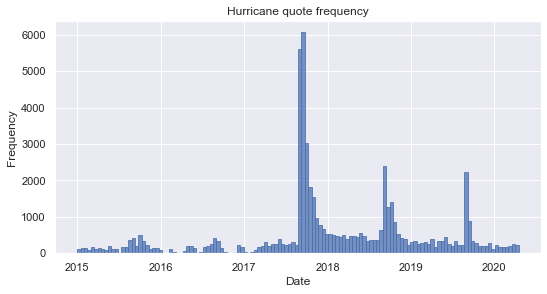

In [169]:
# Plots w.r.t. dates
sns.histplot(x=df_hurricane['date'],bins=130, edgecolor='b', linewidth=0.8)
plt.title("Hurricane quote frequency")
plt.xlabel("Date")
plt.ylabel("Frequency");

We see that the big spike in late 2017 corresponds to the larger-than-usual hurricane season that occurred that year.
We can also see the seasonal trend during hurricane season. Surprisingly it only starts in 2017.

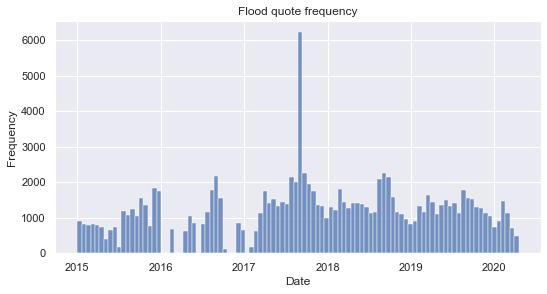

In [171]:
sns.histplot(x=df_flood['date'],bins=100)
plt.title("Flood quote frequency")
plt.xlabel("Date")
plt.ylabel("Frequency");

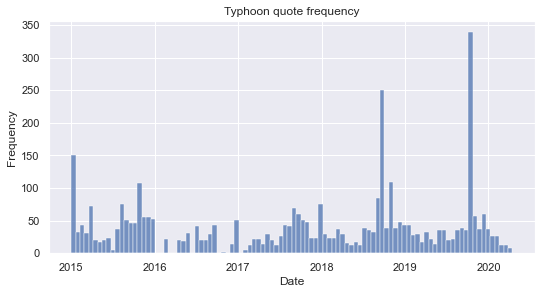

In [172]:
sns.histplot(x=df_typhoon['date'], bins=100)
plt.title("Typhoon quote frequency")
plt.xlabel("Date")
plt.ylabel("Frequency");

We see that we have striking similarities between the occurrences in the "ground truth" dataset and the number of quotes that we observe on specific periods of time

## Example: Hurricanes and Florida

For example purposes, we perform a quick analysis among the quotes that contain
the word "hurricane". We would like to see if we can locate in time and space
the occurrence of notable hurricanes.

In [173]:
# This is a list of all states and their capital
# We may use a more refined list of locations in the future
places = np.array(["Montgomery", "Alabama", "Juneau", "Alaska", "Phoenix", "Arizona", "Little Rock", "Arkansas",
                  "Sacramento", "California", "Denver", "Colorado", "Hartford", "Connecticut", "Dover", "Delaware",
                  "Tallahassee", "Florida", "Atlanta", "Georgia", "Honolulu", "Hawaii", "Boise", "Idaho",
                  "Springfield", "Illinois", "Indianapolis", "Indiana", "Des Moines", "Iowa", "Topeka", "Kansas",
                  "Frankfort", "Kentucky", "Baton Rouge", "Louisiana", "Augusta", "Maine", "Annapolis", "Maryland", 
                  "Boston", "Massachusetts", "Lansing", "Michigan", "St. Paul", "Minnesota", "Jackson", "Mississippi",
                  "Jefferson City", "Missouri", "Helena", "Montana", "Lincoln", "Nebraska", "Carson City", "Nevada",
                  "Concord", "New Hampshire", "Trenton", "New Jersey", "Santa Fe", "New Mexico",
                  "Albany", "New York", "Raleigh", "North Carolina", "Bismarck", "North Dakota", "Columbus", "Ohio",
                  "Oklahoma City", "Oklahoma", "Salem", "Oregon", "Harrisburg", "Pennsylvania", "Providence", "Rhode Island", 
                  "Columbia", "South Carolina", "Pierre", "South Dakota", "Nashville", "Tennessee", "Austin", "Texas", 
                  "Salt Lake City", "Utah", "Montpelier", "Vermont", "Richmond", "Virginia", "Olympia", "Washington",
                  "Charleston", "West Virginia", "Madison", "Wisconsin", "Cheyenne", "Wyoming"])
print(len(places))
pattern = '|'.join(places)
#print(pattern)

100


In [174]:
states = np.array(["Alabama", "Alaska", "Arizona", "Arkansas",
                   "California", "Colorado", "Connecticut", "Delaware",
                   "Florida", "Georgia", "Hawaii", "Idaho",
                   "Illinois", "Indiana", "Iowa", "Kansas",
                   "Kentucky", "Louisiana", "Maine", "Maryland", 
                   "Massachusetts", "Michigan", "Minnesota", "Mississippi",
                   "Missouri", "Montana", "Nebraska", "Nevada",
                   "New Hampshire", "New Jersey", "New Mexico",
                   "New York", "North Carolina", "North Dakota", "Ohio",
                   "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", 
                   "South Carolina", "South Dakota", "Tennessee", "Texas", 
                   "Utah", "Vermont", "Virginia", "Washington",
                   "West Virginia", "Wisconsin", "Wyoming"])
print(len(states))
pattern_states = '|'.join(states)

50


In [175]:
df_loc = df_hurricane[df_hurricane['quotation'].str.contains(pattern_states)]

In [176]:
df_loc.head().quotation

2038                  I thank FEMA for their continued commitment to our Florida communities in their recovery from Hurricane Irma. The reimbursement announced last night for St. John's County is great news,
2747                                             We did a study a few years ago that showed Hurricane Harvey in Texas passed over a very warm body of water, and that greatly increased the amount of rainfall.
2793                                          Every hurricane season, we have lots of questions come in and in the event that something does happen in Central Florida, we're able to update that in real-time,
3044    Backstory: During Hurricane Harvey, the MuttNation Team went to Houston to help relocate existing shelter dogs to free up shelter space for animals separated by their owners. MuttNation asked for ...
3643    It's also the New York tradition. When there's been a hurricane or there's been a flood -- or Hurricane Katrina -- New Yorkers are the first ones in their cars 

In [177]:
print(f"Number of quotations containing hurricane + state/city: %d" % len(df_loc.index))

Number of quotations containing hurricane + state/city: 8383


In [237]:
place_occurrence = [len(df_hurricane[df_hurricane["quotation"].str.contains(place)].index) for place in states]
print(place_occurrence)

[291, 25, 46, 19, 308, 50, 49, 23, 3356, 358, 155, 3, 17, 17, 25, 32, 29, 492, 18, 18, 52, 37, 42, 186, 34, 23, 20, 13, 11, 195, 16, 520, 530, 9, 48, 110, 18, 43, 17, 308, 3, 48, 1913, 10, 12, 209, 301, 36, 22, 3]


In [239]:
# Save these values to generate a US interactive map from it in interactive_maps/us_map.ipynb
df_save = pd.DataFrame({'state': states,
                   'count': place_occurrence})
df_save.to_csv('interactive_maps/hurr_us_count.csv',index=False)
df_save.head()

,state,count
0,Alabama,291
1,Alaska,25
2,Arizona,46
3,Arkansas,19
4,California,308


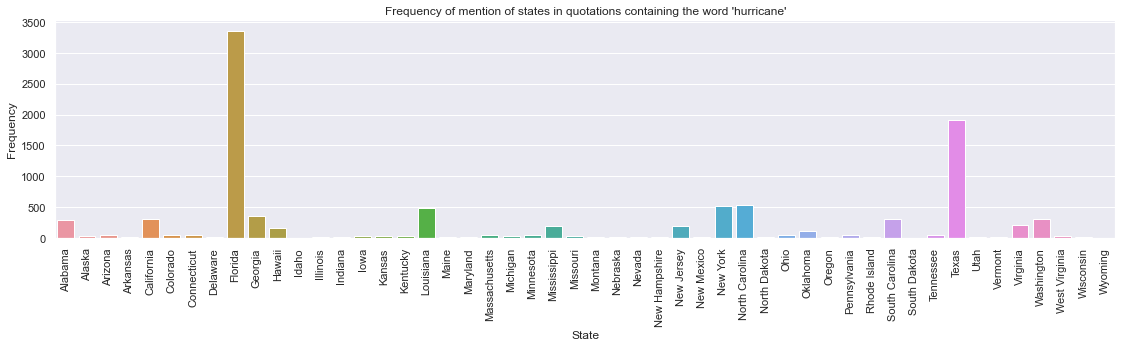

In [207]:
sns.set(rc={'figure.figsize':(19,4)})
plt.xticks(rotation=90)
sns.barplot(x=states, y=place_occurrence)
plt.xlabel("State")
plt.ylabel("Frequency")
plt.title("Frequency of mention of states in quotations containing the word 'hurricane'")
plt.savefig("figures/hurricane_loc", bbox_inches='tight')

Unsurprisingly, quotes that talk about hurricanes also frequently mention
Florida. 

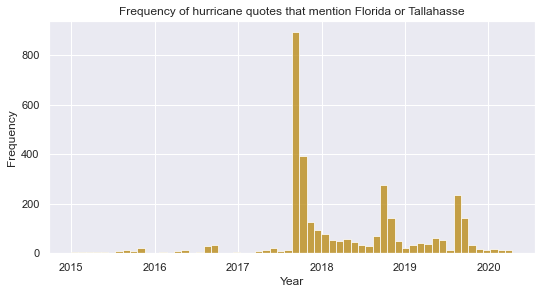

In [206]:
sns.set(rc={'figure.figsize':(8.7, 4.27)})
sns.histplot(x=get_occurrence(df_hurricane, "florida|tallahasse")["date"], bins=60, color='darkgoldenrod')
plt.title("Frequency of hurricane quotes that mention Florida or Tallahasse")
plt.xlabel("Year")
plt.ylabel("Frequency");

## 2nd Example: Detecting the location of a Wildfire

We show for a specific example that it seems possible to infer the location of a major natural disaster (quotation-wise) from both datasets.

In [182]:
df_wildfire = get_occurrence(df_quotes, "wildfire")

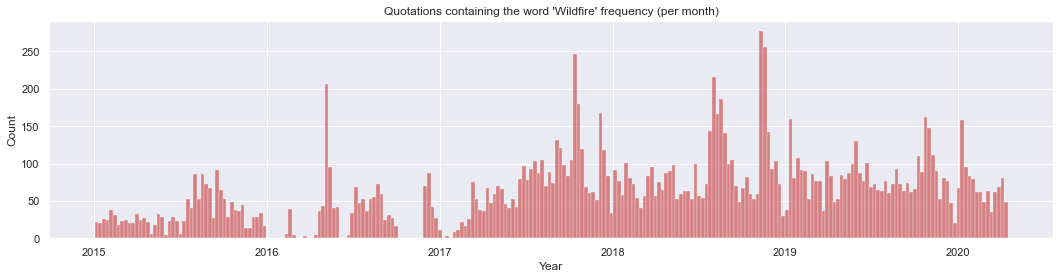

In [228]:
df_wildfire_month = df_wildfire.groupby(pd.Grouper(key='date', axis=0, freq='3M')).sum()
df_wildfire_day = df_wildfire.groupby(pd.Grouper(key='date', axis=0, freq='D')).sum()

plt.figure(figsize=(18,4))
#df_wildfire_day['count'].plot(kind='bar',edgecolor='b')
#plt.xticks(np.linspace(0,len(df_wildfire_day['count']),len(df_wildfire_month['count'])),df_wildfire_month['count'].index.strftime("  %m-%Y ").tolist())
sns.histplot(x=df_wildfire['date'], bins=250, linewidth=0.3, color='indianred',edgecolor='w')
plt.title("Quotations containing the word 'Wildfire' frequency (per month)")
plt.xlabel("Year")
plt.ylabel("Count")
plt.savefig("figures/wildfire_quotes", bbox_inches='tight');

As an example, we can take the main peak in quotation frequency containing the word 'Wildfire', and try to extract the location of that wildfire.

In [229]:
# Retrieve the date at which the main frequency peak occured
WF_date = df_wildfire_day['count'].idxmax()
print(f"Date at which the main frequency peak occured : {WF_date}")

# Retrieve the approriate rows from the natural disaster dataframe
nd_wildfire = nd_frame[(nd_frame['incident_type']=='Fire') & (nd_frame['declaration_title']=='Wildfires')]

nd_wildfire = nd_wildfire.dropna(subset=['incident_begin_date', 'incident_end_date'])

# Convert the date columns from str to datetime
nd_wildfire['incident_begin_date'] = pd.to_datetime(nd_wildfire['incident_begin_date'])
nd_wildfire['incident_begin_date'] = nd_wildfire['incident_begin_date'].apply(lambda p : p.tz_localize(None))
nd_wildfire['incident_end_date'] = pd.to_datetime(nd_wildfire['incident_end_date'])
nd_wildfire['incident_end_date'] = nd_wildfire['incident_end_date'].apply(lambda p : p.tz_localize(None))

# Only keep the rows with WF_date in [incident_begin_date, incident_end_date]
nd_keep = nd_wildfire[(nd_wildfire['incident_begin_date'] <= WF_date) & (nd_wildfire['incident_end_date'] >= WF_date)]
nd_keep.head()

Date at which the main frequency peak occured : 2018-11-13 00:00:00


,fema_declaration_string,disaster_number,state,declaration_type,declaration_date,fy_declared,incident_type,declaration_title,ih_program_declared,ia_program_declared,...,incident_begin_date,incident_end_date,disaster_closeout_date,fips,place_code,designated_area,declaration_request_number,hash,last_refresh,id
49324,EM-3409-CA,3409,CA,EM,2018-11-09T16:50:00Z,2019,Fire,Wildfires,0,0,...,2018-11-08,2018-11-25 23:59:00,NaN,6037,99037,Los Angeles (County),18126,0fa08ab30fcf9d7155f0caf1da4945bf993c7245,2021-07-13T23:02:04Z,60c3b85ca0ee349d710a79af
49325,EM-3409-CA,3409,CA,EM,2018-11-09T16:50:00Z,2019,Fire,Wildfires,0,0,...,2018-11-08,2018-11-25 23:59:00,NaN,6111,99111,Ventura (County),18126,ae1e2bb6f0447384b06fd31ae7a0d5c1e1a882c8,2021-07-13T23:02:04Z,60c3b85ca0ee349d710a79b2
49326,EM-3409-CA,3409,CA,EM,2018-11-09T16:50:00Z,2019,Fire,Wildfires,0,0,...,2018-11-08,2018-11-25 23:59:00,NaN,6007,99007,Butte (County),18126,235966a3eb4704d960dc161d925a0f4cc3ea1d56,2021-07-13T23:02:04Z,60c3b85ca0ee349d710a79aa
49327,DR-4407-CA,4407,CA,DR,2018-11-12T20:28:00Z,2019,Fire,Wildfires,1,0,...,2018-11-08,2018-11-25 23:59:00,NaN,6111,99111,Ventura (County),18127,3f221e0f56229a361a105b9526737aaded31dc19,2021-07-13T23:02:16Z,60c3b869a0ee349d710b66c3
49328,DR-4407-CA,4407,CA,DR,2018-11-12T20:28:00Z,2019,Fire,Wildfires,1,0,...,2018-11-08,2018-11-25 23:59:00,NaN,6007,99007,Butte (County),18127,5c84c04921040155f08bde14739d02497dd41039,2021-07-13T23:02:16Z,60c3b869a0ee349d710b66ad


In [230]:
location = nd_keep['state'].value_counts().idxmax()
print(f"Most probable state location of the wildfires that caused the peak (on {WF_date}) : {location[:10]} (California), \n\
which coincides with the massive wildfires that indeed took place in November 2018. We therefore see that by targetting a \n\
peak of concern in the quotation dataset, we can extract the most probable location of the natural event, and we could \n\
imagine building a map of the US reconstructing that information in space from the quotes.")

Most probable state location of the wildfires that caused the peak (on 2018-11-13 00:00:00) : CA (California), 
which coincides with the massive wildfires that indeed took place in November 2018. We therefore see that by targetting a 
peak of concern in the quotation dataset, we can extract the most probable location of the natural event, and we could 
imagine building a map of the US reconstructing that information in space from the quotes.


## Last part: Speaker analysis

Some quick data exploration.

In [187]:
# Count if there are some speakers that occur more often
speaker_count = df_quotes["speaker"].value_counts()
speaker_count.head(10)

None                      514208
President Donald Trump      6458
Donald Trump                3558
Narendra Modi               3007
President Trump             2921
Benjamin Netanyahu          2253
Recep Tayyip Erdogan        2026
Vladimir Putin              2011
President Barack Obama      1836
Hillary Clinton             1477
Name: speaker, dtype: int64

In [188]:
speaker_count = df_loc["speaker"].value_counts()
speaker_count.head(10)

None                      2674
Gov. Rick Scott            201
President Donald Trump     129
Roy Cooper                 120
Greg Abbott                114
Ron DeSantis                78
Governor Rick Scott         77
Marco Rubio                 68
President Trump             61
Henry McMaster              58
Name: speaker, dtype: int64

If we look at the speakers over all quotes we find that the most frequently
occurring ones are national presidents or governors of concerned states in the US (which makes sense). While if we restrict ourselves to quotes
that mention notable places in the USA, the speakers are mostly american
politicians. Regardless it is surprising that we do not see any "influential"
person that is not a politician.

Also we note that for most quotes we are not sure of who is the speaker.

### Topic detection and Sentiment analysis

Using the parquet file, we will try to see if there are correlation between the speakers, depending on their occupation, and the subjects present in their quotes.

In [189]:
from pathlib import Path
from glob import glob
import spacy

nlp = spacy.load("en_core_web_sm")

In [190]:
if Path("./data/df_quotes.pickle").is_file():
    df_quotes = pd.read_pickle("./data/df_quotes.pickle")
else:
    df_quotes = pd.read_json(
        "data/natural_disaster_quotes.json.bz2", lines=True, compression="bz2"
    )
    df_quotes.to_pickle("./data/df_quotes.pickle")

print(f"Number of quotes: %d" % len(df_quotes.index))

Number of quotes: 1480711


In [191]:
# Turn the parquets into exploded pickles
files = sorted(glob("data/speaker_attributes.parquet/part*"))
for (i, f) in enumerate(files):
    if Path("data/speaker_chunks/chunk_" + str(i) + ".pickle").is_file():
        continue
    else:
        chunk = pd.read_parquet(f, engine="pyarrow").explode("aliases")
        chunk = chunk[chunk.aliases.isin(df_quotes.speaker)]
        chunk.to_pickle("data/speaker_chunks/chunk_" + str(i) + ".pickle")

In [192]:
files = sorted(glob("data/speaker_chunks/chunk*"))
chunks = pd.DataFrame()

for f in files:
    chunk = pd.read_pickle(f)
    chunks = chunks.append(chunk)

chunks.head(2)

""


In [193]:
df_labels = pd.read_csv(
    "data/wikidata_labels_descriptions_quotebank.csv.bz2",
    compression="bz2",
    index_col="QID",
)
df_labels.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data/wikidata_labels_descriptions_quotebank.csv.bz2'

In [ ]:
# Turn the wikinodes into human readable labels
cols = [
    "nationality",
    "occupation",
    "party",
    "academic_degree",
    "candidacy",
    "religion",
]
for col in cols:
    print(col)
    chunks[col] = chunks[col].apply(
        lambda l: [df_labels.loc[q]["Label"] for q in l] if l is not None else l
    )

speakers = chunks
chunks.head(2)
print(chunks.candidacy.iloc[1])

nationality
occupation
party
academic_degree
candidacy
religion
['2000 United States presidential election', '2004 United States presidential election', '1998 Texas gubernatorial election', '1978 United States House of Representatives elections']


In [ ]:
# Count and display the profession of the speakers
plt.figure(figsize=(7,4))
speakers.occupation.explode().value_counts().head(10).plot(kind="bar")
plt.savefig("figures/occupation.png", bbox_inches="tight")

NameError: name 'plt' is not defined

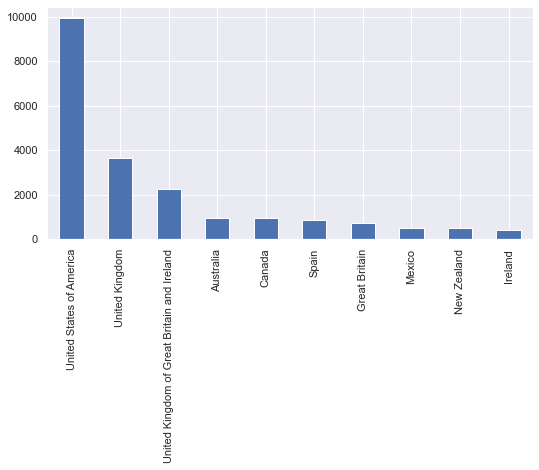

In [ ]:
# Count and display Political party
speakers.nationality.explode().value_counts().head(10).plot(kind="bar");

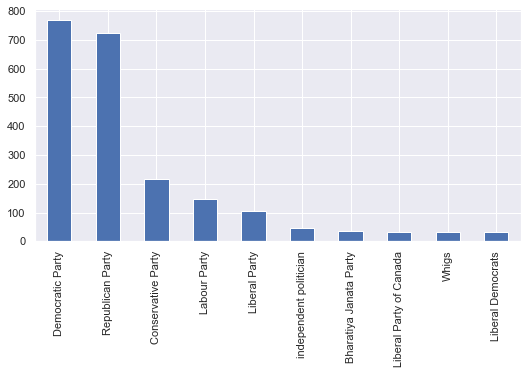

In [ ]:
# Count and display Political party
chunks.party.explode().value_counts().head(10).plot(kind="bar");

In [ ]:
# Do topic detection on the democrats and the republicans

## Get left wingers TODO? include more parties than dems
democrats = speakers[
    speakers.party.apply(lambda l: "Democratic Party" in l if l is not None else False)
]

## Get right wingers TODO? include more parties than repubs
republicans = speakers[
    speakers.party.apply(lambda l: "Republican Party" in l if l is not None else False)
]

## Get lefties quotes
left_quotes = df_quotes[df_quotes.speaker.isin(democrats.aliases)]
left_book = left_quotes.quotation.str.cat(sep="\n")
with open("data/left_book.txt", "w", encoding="utf-8") as f:
    f.write(left_book)

## Get righties quotes
right_quotes = df_quotes[df_quotes.speaker.isin(republicans.aliases)]
right_book = right_quotes.quotation.str.cat(sep="\n")
with open("data/right_book.txt", "w", encoding="utf-8") as f:
    f.write(right_book)

In [ ]:
# Get the quotes from the people whose occupation is researcher
researchers = speakers[
    speakers.occupation.apply(lambda l: "researcher" in l if l is not None else False)
].aliases
res_quotes = df_quotes[df_quotes.speaker.isin(researchers)]
res_text = res_quotes.quotation.str.cat(sep="\n")

with open("data/researcher_book.txt", "w", encoding="utf-8") as f:
    f.write(res_text)

In [ ]:
def get_chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i : i + n]


# Get the quotes into chunks
from nltk.corpus import PlaintextCorpusReader

books = PlaintextCorpusReader("data", "(researcher|politician)_book.txt")
print(books.fileids())
limit = 600
size = 50

chunks = list()
chunk_class = list()
book_id = {f: n for n, f in enumerate(books.fileids())}  # dictionary of books

for f in books.fileids():
    sentences = books.sents(f)
    print(f, ":")
    print("Num of sentences:", len(sentences))

    chunks_of_sents = [x for x in get_chunks(sentences, size)]
    chs = list()

    for c in chunks_of_sents:
        grouped_chunk = list()
        for sent in c:
            grouped_chunk.extend(sent)
        chs.append(" ".join(grouped_chunk))
    print("Num of chunks:", len(chs), "\n")

    # filter to the limit, to have the same number of chunks per book
    chunks.extend(chs[:limit])
    chunk_class.extend([book_id[f] for _ in range(len(chs[:limit]))])

['politician_book.txt', 'researcher_book.txt']
politician_book.txt :
Num of sentences: 67624
Num of chunks: 1353 

researcher_book.txt :
Num of sentences: 137120
Num of chunks: 2743 



In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

vectorizer = CountVectorizer()

X = vectorizer.fit_transform(chunks)

print("Number of samples:", X.toarray().shape[0])
print("Number of features:", X.toarray().shape[1])

Y = chunk_class

X, Y = shuffle(X, Y, random_state=0)

# split into training and test set
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

Number of samples: 1200
Number of features: 35875


### Logistic regression
We perform a logistic regression to see if we can differentiate the speakers between their profession, here between a politician and a researcher.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing

accs = []

scaler = preprocessing.MaxAbsScaler()

X_scaled = X_train.log1p()
X_scaled = scaler.fit(X_scaled).transform(X_scaled)

# the grid of regularization parameter
grid = [0.01, 0.1, 1, 10, 100, 1000, 10000]

for c in grid:
    # print("----", c)

    # initialize the classifier
    # Increase max iter by a lot because scaling gave worst results, but this
    # causes it to take a lot of time to compute.... using MaxAbsScaler was
    # recommended for sparse inputs but it gives worse results than to simply
    # increase the number of iterations
    clf = LogisticRegression(random_state=0, C=c) 

    # crossvalidate
    scores = cross_val_score(clf, X_scaled, Y_train, cv=10)
    accs.append(np.mean(scores))

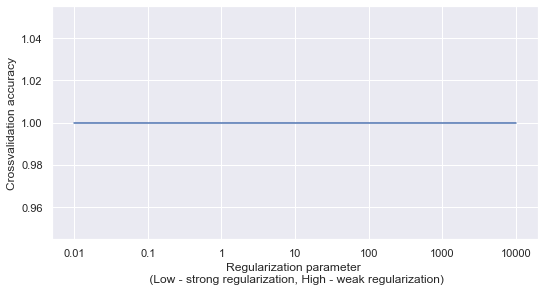

In [ ]:
plt.plot(accs)
plt.xticks(range(len(grid)), grid)
plt.xlabel('Regularization parameter \n (Low - strong regularization, High - weak regularization)')
plt.ylabel('Crossvalidation accuracy');

In [ ]:
clf = LogisticRegression(random_state=0, C = 100, max_iter=1000).fit(X_scaled, Y_train)

#predict on the test set
X_scaled_test = X_test.log1p()
X_scaled_test = scaler.fit(X_scaled_test).transform(X_scaled_test)
print('Accuracy:',clf.score(X_scaled_test,Y_test))

Accuracy: 0.9958333333333333


We get very high accuracy! This means the models can easily recognize wheter the speaker is a researcher or a politician from its vocabulary.

In [ ]:
# Get the chunks again (into smaller chunks)
book_id = {f: n for n, f in enumerate(books.fileids())}  # dictionary of books
chunks = list()
chunk_class = (
    list()
)  # this list contains the original book of the chunk, for evaluation

limit = 60  # how many chunks total
size = 50  # how many sentences per chunk/page

for f in books.fileids():
    sentences = books.sents(f)
    print(f)
    print("Number of sentences:", len(sentences))

    # create chunks
    chunks_of_sents = [
        x for x in get_chunks(sentences, size)
    ]  # this is a list of lists of sentences, which are a list of tokens
    chs = list()

    # regroup so to have a list of chunks which are strings
    for c in chunks_of_sents:
        grouped_chunk = list()
        for s in c:
            grouped_chunk.extend(s)
        chs.append(" ".join(grouped_chunk))
    print("Number of chunks:", len(chs), "\n")

    # filter to the limit, to have the same number of chunks per book
    chunks.extend(chs[:limit])
    chunk_class.extend([book_id[f] for _ in range(len(chs[:limit]))])

politician_book.txt
Number of sentences: 67624
Number of chunks: 1353 

researcher_book.txt
Number of sentences: 137120
Number of chunks: 2743 



In [ ]:
STOP_WORDS = spacy.lang.en.stop_words.STOP_WORDS

processed_docs = list()
for doc in nlp.pipe(chunks, batch_size = 10):
    ents = doc.ents
    
    doc = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    doc = [token for token in doc if token not in STOP_WORDS and len(token) > 2]
    doc.extend([str(entity) for entity in ents if len(entity) > 1])

    processed_docs.append(doc)
docs = processed_docs
# print(docs)
del(processed_docs)

In [ ]:
from gensim.models.phrases import Phrases

bigrams = Phrases(docs)

for idx in range(len(docs)):
    for token in bigrams[docs[idx]]:
        if '_' in token:
            docs[idx].append(token)

In [ ]:
from gensim.corpora import Dictionary
dictionary = Dictionary(docs)

max_freq = 0.6
min_wordcount = 3

dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

corpus = [dictionary.doc2bow(doc) for doc in docs]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of chunks: %d' % len(corpus))

Number of unique tokens: 4016
Number of chunks: 120


In [ ]:
# models
from gensim.models import LdaMulticore

params = {"passes": 10, "random_state": 0}
base_models = dict()
model = LdaMulticore(
    corpus=corpus,
    num_topics=2,
    id2word=dictionary,
    workers=6,
    passes=params["passes"],
    random_state=params["random_state"],
)

In [ ]:
model.show_topics(num_words=20)

[(0,
  '0.003*"bushfire" + 0.003*"home" + 0.003*"hurricane" + 0.003*"weather" + 0.002*"high" + 0.002*"cause" + 0.002*"tell" + 0.002*"Fire" + 0.002*"family" + 0.002*"place" + 0.002*"provide" + 0.002*"burn" + 0.002*"try" + 0.002*"little" + 0.002*"week" + 0.002*"system" + 0.002*"fight" + 0.002*"important" + 0.002*"event" + 0.002*"hard"'),
 (1,
  '0.007*"kill" + 0.005*"Soleimani" + 0.005*"Trump" + 0.004*"attack" + 0.004*"try" + 0.003*"United" + 0.003*"States" + 0.003*"Iran" + 0.003*"United_States" + 0.003*"military" + 0.003*"american" + 0.002*"Democrats" + 0.002*"President" + 0.002*"job" + 0.002*"strike" + 0.002*"action" + 0.002*"plan" + 0.002*"protect" + 0.002*"the United States" + 0.002*"Americans"')]

In [ ]:
sorted(model[corpus[0]], key=lambda x: x[1], reverse=True);

In [ ]:
model.show_topics(num_words=5);

In the following figure, we observe the two main topics found in the quotes. On one hand, the vocabulary seems very political and on the other hand it seems more related to climate and crisis. We could argue that the first topic concerns mostly politicians and the second mostly researchers, or other people concerned by climate, including maybe politicians.

In [ ]:
import pyLDAvis.gensim_models
# plot topics
data =  pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
pyLDAvis.display(data)

C:\Users\omidk\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


If this figure is not visible, see in the data story.

In [ ]:
# pyLDAvis.save_html(data, 'figures/lda_res_pol.html', template_type="general")

C:\Users\omidk\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Idea: build a model to predict wheter a speaker republican or democrat (right or left / politician or researcher). Use a subjective dictionary and build a feature vector of 1 and 0, 1 if the speaker used the word at least 0 otherwise.

In [ ]:
# Test dictionary to build feature vector
climate_dict = ("climate", "climate change", "global warming")

df_test = df_hurricane[df_hurricane['quotation'].str.contains('|'.join(climate_dict))]
print(f"Number of quotes containing words in the dictionary: %d" % len(df_test.index))

In [ ]:
# Tried building dictionary from most frequent words (without stopwords)
quotes = ' '.join(df_wildfire['quotation'])
nlp.max_length = 3383899
doc = nlp(quotes)

spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
tokens = [token.text for token in doc if not token.is_stop]

In [ ]:
import string

punc = [char for char in string.punctuation]

tokens = [token.text for token in doc if (not token.is_stop and str(token) not in punc and str(token) != "..." and str(token) != "--")]

In [ ]:
from collections import Counter
occurences = Counter(tokens)
top_occurences = dict((k, v) for k, v in occurences.items() if v >= 1000)
print(top_occurences)

In [ ]:
def one_hot(quotes, dictionary):
    one_hot = np.zeros(len(dictionary))
    for i, v in quotes.items():
        for word in v.split(" "):
            if word in dictionary:
                one_hot[dictionary.index(word)] = 1
    return one_hot

In [ ]:
speaker_fvec = df_hurricane.groupby('speaker').apply(lambda x: one_hot(x.quotation, curated_list))
speaker_fvec.head(100)

This idea was abandonned for multiple reasons: there might not be enough data to build a meaningful model, but either way the main problem is that the assumption that right winged politician would never talk about climate is flawed. Similar ideas were put to better use in the previous analysis

### Sentiment analysis

We want to see if we can differentiate researchers and politicians with the sentiment in their speech. We would expect researchers to be more negative (critisising the action taken by the government), and most politicians to be more positive since they will be praysing their reactions to the situation.

In [ ]:
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

with open("data/politician_book.txt", "r", encoding="utf-8") as pol_f:
    pol_txt = [next(pol_f) for _ in range(1000)]

vs = analyzer.polarity_scores(pol_txt)

C:\Users\omidk\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print('Negative sentiment:',vs['neg'])
print('Neutral sentiment:',vs['neu'])
print('Positive sentiment:',vs['pos'])
print('Compound sentiment:',vs['compound'])

Negative sentiment: 0.21
Neutral sentiment: 0.675
Positive sentiment: 0.115
Compound sentiment: -1.0


C:\Users\omidk\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
analyzer = SentimentIntensityAnalyzer()

with open("data/researcher_book.txt", "r", encoding="utf-8") as res_f:
    res_txt = [next(res_f) for _ in range(1000)]

vs = analyzer.polarity_scores(res_txt)

C:\Users\omidk\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print('Negative sentiment:',vs['neg'])
print('Neutral sentiment:',vs['neu'])
print('Positive sentiment:',vs['pos'])
print('Compound sentiment:',vs['compound'])

Negative sentiment: 0.125
Neutral sentiment: 0.763
Positive sentiment: 0.112
Compound sentiment: -1.0


C:\Users\omidk\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We can not conclude anything meaningful with these results...